# Target Features

In [35]:
# target_features = ['GrainYield']
target_features = ['Days2Maturity']

# Importing Libraries

In [36]:
import os
import csv
import numpy as np
import pandas as pd
from copy import copy
from datetime import datetime as dt

# Dictionaries
import json
from pprint import pprint

# Iterate in loops
import itertools
from itertools import zip_longest

# Simpsons integration
from numpy import trapz
from scipy.integrate import simps

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# To display df nicely in loops
from IPython.display import display 
# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',100)

# # For displaying max rows in series
# pd.options.display.max_rows = 10

# Importing data

In [37]:
# Prints the current working directory
os.getcwd()
# os.listdir()

'C:\\Users\\fahad\\MegaSync\\NMBU\\GitHub\\vPheno'

## Finding Username folder to make general path for multi PC use

In [38]:
username = str(os.getcwd()).split('\\')[2]
user_path = r'C:/Users/'+username+'/'
username, user_path

('fahad', 'C:/Users/fahad/')

## Declaring Import paths

In [39]:
main_path = r'./Data/'
path = r'./Data/3. merged data/'
if target_features[0] == 'GrainYield':
    export_path = './Data/4. results_GY/'
    export_path_comparability = './Data/4. results/comparability/'
elif target_features[0] == 'Days2Maturity':
    export_path = './Data/4. results_DM/'
    export_path_comparability = './Data/4. results_dm/comparability/'

# Create export_path folder if not exists already
os.makedirs(path, exist_ok=True)
os.makedirs(export_path, exist_ok=True)
os.makedirs(export_path_comparability, exist_ok=True)

# os.listdir(path)

In [40]:
# Making dictionary of files in each folder, in case there are multiple types of data
dict_paths = {}
def explore(starting_path):
    for dirpath, dirnames, filenames in os.walk(starting_path):
        dict_paths[dirpath.split('/')[-2]] = filenames
#     pprint(dict_paths)
explore(path)

# Data Preparation
## Creating list of complete files

In [41]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files found in the directory')
# files_with_address
# files_list

14 files found in the directory


## Data Checking/control

### Check for duplicate filenames

In [42]:
print('Total number of files are :', len(files_list))

print('Number of unique file names are:', len(set(files_list)))

print('There is/are', len(files_list) - len(set(files_list)),'duplicate file name/names.')
if len(files_list) - len(set(files_list)) > 0:
    raise NameError

Total number of files are : 14
Number of unique file names are: 14
There is/are 0 duplicate file name/names.


# Importing data files to Pandas

In [43]:
all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("-", "_")
    file_name = file_name.replace(")", "")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(".", "")
    # Test: Check if the same date is already present in the current dict key
    if df_name in all_df:
        print(f'A file with the same name {df_name} has already been imported. \n Please check if there is duplication of data.')
        raise NameError
    all_df.append(df_name)

    locals()[df_name] = pd.read_csv(data, index_col=False)
    print(df_name, '=====', locals()[df_name].shape)
# all_df

Graminor_2019_Simps ===== (600, 122)
Graminor_2019_Trapz ===== (600, 122)
Graminor_2020_Simps ===== (800, 122)
Graminor_2020_Trapz ===== (800, 122)
Masbasis_2019_Simps ===== (528, 123)
Masbasis_2019_Trapz ===== (528, 123)
Masbasis_2020_Simps ===== (624, 125)
Masbasis_2020_Trapz ===== (624, 125)
Robot_2020_Simps ===== (96, 124)
Robot_2020_Trapz ===== (96, 124)
Staur_2019_Simps ===== (1328, 126)
Staur_2019_Trapz ===== (1328, 126)
Staur_2020_Simps ===== (1488, 123)
Staur_2020_Trapz ===== (1488, 123)


In [44]:
print(f'Total imported {len(all_df)}')
# all_df

Total imported 14


## Importing Weather variables, yield columns, spectral indices, base indices columsn list

In [45]:
a_file = open(main_path+'vollebekk_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string

# Converting it to python format
weather_cols_vollebekk = json.loads(output_str)
a_file.close()

pprint(len(weather_cols_vollebekk))

80


In [46]:
a_file = open(main_path+'staur_weather_columns.json', "r")
output_str = a_file.read()
# The file is imported as string

# Converting it to python format
weather_cols_staur = json.loads(output_str)
a_file.close()

pprint(len(weather_cols_staur))

80


In [47]:
a_file = open(main_path+"yield_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to python format
yield_cols = json.loads(output_str)
a_file.close()
print(yield_cols)

['Entry', 'CodeName', 'Block', 'Pedigree', 'Replicates', 'iBlock', 'Heading_Date', 'Maturity_Date', 'Days2Maturity', 'Line', 'Lodging', 'GrainYield', 'Days2Heading', 'Name']


In [48]:
a_file = open(main_path+"spectral_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to python format
spectral_indices_all = json.loads(output_str)
a_file.close()
print(spectral_indices_all)

['NDVI', 'MTCI', 'DVI', 'GDVI', 'EXG', 'EXGR', 'RDVI', 'TDVI', 'GNDVI', 'NDRE', 'SCCI', 'EVI', 'TVI', 'VARI', 'GARI', 'GCI', 'GLI', 'NLI', 'MNLI', 'SAVI', 'GSAVI', 'OSAVI', 'GOSAVI', 'MSAVI2', 'MSR', 'GRVI', 'WDRVI', 'SR']


In [49]:
a_file = open(main_path+"base_indices_columns.json", "r")
output_str = a_file.read()

# The file is imported as string
# Converting it to python format
base_indices = json.loads(output_str)
a_file.close()
print(base_indices)

['Blue', 'Green', 'Red', 'RedEdge', 'NIR']


## Defining categories of features

In [50]:
# ToDo: Add check for duplicate columns in the df
base_indices
spectral_indices_all 
drop_indices = ['EVI', 'GLI', 'MTCI']
spectral_indices = [x for x in spectral_indices_all if x not in drop_indices]

# Staur weather columns are all also present in Vollebekk weather so they can be use as general weather features
weather_features = weather_cols_staur.copy()
environment_var = weather_features + ['Staur_Env', 'Vollebekk_Env']
# yield_cols

# Dropping DF which donot have the Target Feature

In [51]:
# Dropping unnecessary columns
all_df_dm = []
for df in all_df:
    temp_df = locals()[df].copy()
    if target_features[0] in temp_df.columns.tolist():
        all_df_dm.append(df)
#         print(df)

In [52]:
all_df_simps = [x for x in all_df_dm if 'Simps' in x]
all_df_trapz = [x for x in all_df_dm if 'Trapz' in x]
# all_df_simps, all_df_trapz

# Dropping unnecessary columns


In [53]:
# Dropping unnecessary columns
for df in all_df_dm:
    temp_df = locals()[df].copy()
    locals()[df] = temp_df[base_indices+spectral_indices_all+environment_var+['Name',target_features[0]]]
    print(df, temp_df.shape, '==>', locals()[df].shape)

Masbasis_2019_Simps (528, 123) ==> (528, 117)
Masbasis_2019_Trapz (528, 123) ==> (528, 117)
Masbasis_2020_Simps (624, 125) ==> (624, 117)
Masbasis_2020_Trapz (624, 125) ==> (624, 117)
Robot_2020_Simps (96, 124) ==> (96, 117)
Robot_2020_Trapz (96, 124) ==> (96, 117)
Staur_2019_Simps (1328, 126) ==> (1328, 117)
Staur_2019_Trapz (1328, 126) ==> (1328, 117)


# Dealing with Nan values

## Dropping Missing values

In [54]:
# Dropping rows with missing value in any column
for df in all_df_dm:
    temp_df = locals()[df].copy()
    locals()[df] = temp_df.dropna(axis=0)
    print(temp_df.shape[0] - locals()[df].shape[0], ' rows dropped in ', df)
#     print(locals()[df].shape[0])

0  rows dropped in  Masbasis_2019_Simps
0  rows dropped in  Masbasis_2019_Trapz
112  rows dropped in  Masbasis_2020_Simps
112  rows dropped in  Masbasis_2020_Trapz
8  rows dropped in  Robot_2020_Simps
8  rows dropped in  Robot_2020_Trapz
800  rows dropped in  Staur_2019_Simps
800  rows dropped in  Staur_2019_Trapz


# Plotting Grain Yield

In [55]:
# import matplotlib.pyplot as plt
# rng = np.random.RandomState(10)  # deterministic random data
# a = np.hstack((rng.normal(size=1000),
#                rng.normal(loc=5, scale=2, size=1000)))
# _ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
# Text(0.5, 1.0, "Histogram with 'auto' bins")
# plt.show()

In [56]:
# plt.hist(temp_df.values.reshape((20,int(len(temp_df.values)/20))).T)
# plt.show()

In [57]:
# plt.hist(np.histogramdd(temp_df.values)[0], np.histogramdd(temp_df.values)[1])
# np.histogramdd(temp_df.values)

In [58]:
# for df in all_df_simps:
#     temp_df = locals()[df].GrainYield.copy()
#     temp_df.dropna(axis=0)
#     plt.hist(temp_df.values)
# #     plt.hist(temp_df.values.reshape((20,int(len(temp_df.values)/20))))
#     plt.title(df)
#     plt.show()

# Data Normalization

## Plot one index for different fields to check comparability

In [59]:
# for col in base_indices+spectral_indices:
# #     col='Blue'
#     fig_size=(8, 5)
#     fig, ax = plt.subplots(figsize=fig_size)
#     plots = ax

#     for df in all_df_simps:
# #         if not 'Robot' in df and  not 'Staur' in df:
# #         if 'Gram' in df and  'Masb' in df:
# #             if '2020' in df:
#         temp_df = locals()[df].copy()
#         ax.boxplot(sorted(temp_df[col].values), positions = [all_df_simps.index(df)], labels=[df.split('_')[0][:5]+'_'+df.split('_')[1]])
# #         ax.plot(sorted(temp_df[col].values), label=df.split('_')[0]+'_'+df.split('_')[1])
#     # Printing the band/index name in plot of the fiels_sample for reference
#     text = col
#     ax.text(.98, .98, text, ha='right', va='top', weight=100, color='blue', fontsize ='xx-large', transform=ax.transAxes)

#     ax.legend(loc=1)
#     plt.tight_layout()
#     plt.savefig(export_path_comparability+col+'_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)
#     plt.show()
# #     break

In [60]:
# for col in base_indices+spectral_indices:
# #     col='Blue'
#     fig_size=(8, 5)
#     fig, ax = plt.subplots(figsize=fig_size)
#     plots = ax

#     for df in all_df_simps:
# #         if not 'Robot' in df and  not 'Staur' in df:
# #         if 'Gram' in df and  'Masb' in df:
# #             if '2020' in df:
#         temp_df = locals()[df].copy()
# #         ax.boxplot(sorted(temp_df[col].values), positions = [all_df_simps.index(df)], labels=[df.split('_')[0][:5]+'_'+df.split('_')[1]])
#         ax.plot(sorted(temp_df[col].values), label=df.split('_')[0]+'_'+df.split('_')[1])
#     # Printing the band/index name in plot of the fiels_sample for reference
#     text = col
#     ax.text(.87, .6, text, ha='center', va='top', weight=100, color='blue', fontsize ='xx-large', transform=ax.transAxes)

#     ax.legend(loc=1)
#     plt.tight_layout()
# #     plt.savefig(export_path_comparability+col+'_sorted.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)
#     plt.show()
# #     break

In [61]:
# for col in base_indices+spectral_indices:
# #     col='Blue'
#     fig_size=(8, 5)
#     fig, ax = plt.subplots(figsize=fig_size)
#     plots = ax

#     for df in all_df_simps:
# #         if not 'Robot' in df and  not 'Staur' in df:
# #         if 'Gram' in df and  'Masb' in df:
# #             if '2020' in df:
#         temp_df = locals()[df].copy()
# #         ax.boxplot(sorted(temp_df[col].values), positions = [all_df_simps.index(df)], labels=[df.split('_')[0][:5]+'_'+df.split('_')[1]])
#         ax.plot((temp_df[col].values), label=df.split('_')[0]+'_'+df.split('_')[1])
#     # Printing the band/index name in plot of the fiels_sample for reference
#     text = col
#     ax.text(.87, .6, text, ha='center', va='top', weight=100, color='blue', fontsize ='xx-large', transform=ax.transAxes)

#     ax.legend(loc=1)
#     plt.tight_layout()
# #     plt.savefig(export_path_comparability+col+'_random.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)
#     plt.show()
# #     break

# Outliers Deletion

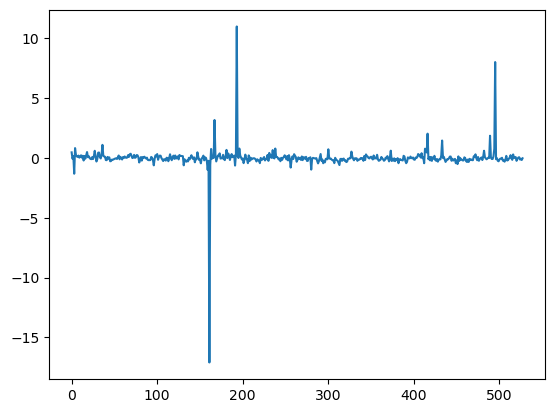

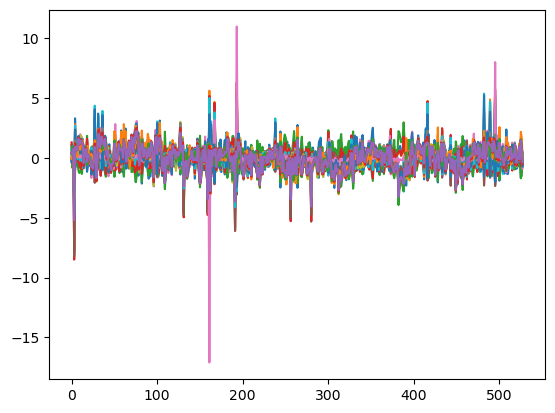

In [62]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

scaler = StandardScaler()
temp_df = Staur_2019_Trapz
temp_df_1 = scaler.fit_transform(X=temp_df.iloc[:,:25].values)
# plt.plot(temp_df.iloc[:,:25].values)
# plt.plot(locals()[df].iloc[:,:25])
plt.plot(zscore(temp_df['EVI']))
plt.show()
plt.plot(temp_df_1)
plt.show()
# plt.legend(locals()[df].columns)
# plt.plot(temp_df_1)



There were a few outliers in EVI in Staur_2019 dataset which were more than 10 std dev away from mean. So a crieteria is being set to drop all values which are more than 3 std dev away from the mean.

## Dropping outliers

In [63]:
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

drop_thres = 3
for df in all_df_dm:
    temp_df = locals()[df].copy()
    temp_df_z = locals()[df].copy()
    for col in temp_df.columns:
        # Checking if the column is not a yield column
        if col not in yield_cols+environment_var:
            # Calculating z score for temp_df_z dataset
            temp_df_z[col] = zscore(temp_df_z[col])
    
            # listing entries which are more than the threshold value for zscore
            drop_entries = temp_df_z[(temp_df_z[col] > drop_thres) | (temp_df_z[col] < -drop_thres)].index 
            
            # Using the values in temp_df_z, checking those which are more than 3 std dev away from mean
            # and dropping them in temp_df and temp_df_z for as well for consistency
            temp_df.drop(drop_entries, inplace=True)
            temp_df_z.drop(drop_entries, inplace=True)
            
    dropped_rows = locals()[df].shape[0] - temp_df.shape[0]
    print(dropped_rows, 'rows, ',("%0.2f" % ((dropped_rows/locals()[df].shape[0])*100)),'% dropped in ', df)
    
    locals()[df] = temp_df.copy()
#     print(df)

43 rows,  8.14 % dropped in  Masbasis_2019_Simps
38 rows,  7.20 % dropped in  Masbasis_2019_Trapz
16 rows,  3.12 % dropped in  Masbasis_2020_Simps
13 rows,  2.54 % dropped in  Masbasis_2020_Trapz
2 rows,  2.27 % dropped in  Robot_2020_Simps
1 rows,  1.14 % dropped in  Robot_2020_Trapz
48 rows,  9.09 % dropped in  Staur_2019_Simps
47 rows,  8.90 % dropped in  Staur_2019_Trapz


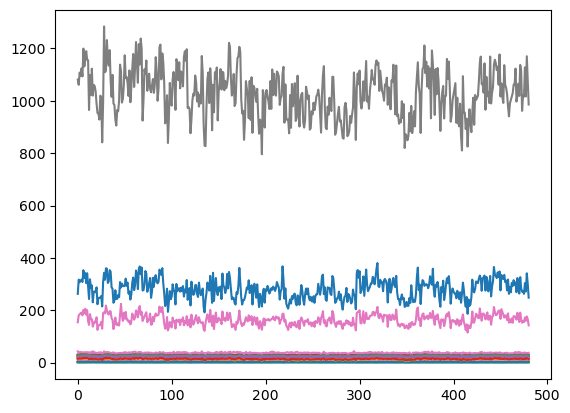

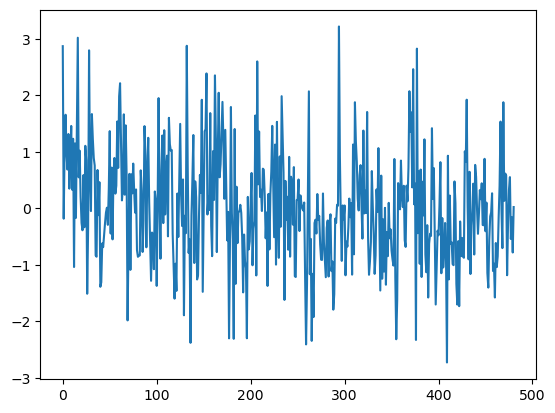

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
temp_df = Staur_2019_Trapz
temp_df_1 = scaler.fit_transform(X=temp_df.iloc[:,:25].values)
plt.plot(temp_df.iloc[:,:25].values)
plt.show()
# plt.plot(locals()[df].iloc[:,:25])
plt.plot(zscore(locals()[df]['EVI']))
# plt.legend(locals()[df].columns)
# plt.plot(temp_df_1)

plt.show()

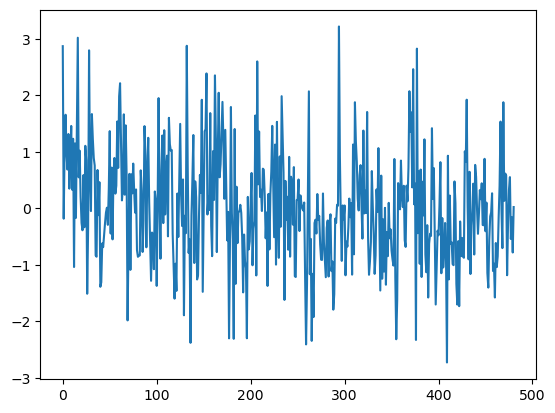

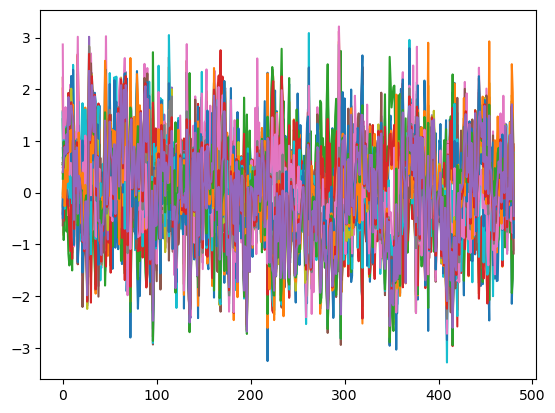

In [65]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

scaler = StandardScaler()
temp_df = Staur_2019_Trapz
temp_df_1 = scaler.fit_transform(X=temp_df.iloc[:,:25].values)
# plt.plot(temp_df.iloc[:,:25].values)
# plt.plot(locals()[df].iloc[:,:25])
plt.plot(zscore(temp_df['EVI']))
plt.show()
plt.plot(temp_df_1)
plt.show()
# plt.legend(locals()[df].columns)
# plt.plot(temp_df_1)



## Normalizing the data using Z-Score from scipy

In [66]:
# X_train = np.array([[ 1., -1.,  2.],
#                     [ 2.,  0.,  0.],
#                     [ 0.,  1., -1.]])

# print(scaler.mean_)
# print(scaler.scale_)
# print(scaler.fit_transform(X_train))
# zscore(X_train[0])

In [118]:
from scipy.stats import zscore

for df in all_df_dm:
    temp_df = locals()[df].copy()
    for col in temp_df.columns:
        # Checking if the column is not a yield column
        if col not in yield_cols+environment_var:
            temp_df[col] = zscore(temp_df[col])

    locals()[df] = temp_df.copy()
    print(df)

Masbasis_2019_Simps
Masbasis_2019_Trapz
Masbasis_2020_Simps
Masbasis_2020_Trapz
Robot_2020_Simps
Robot_2020_Trapz
Staur_2019_Simps
Staur_2019_Trapz


## Checking comparability after normalization

No handles with labels found to put in legend.


6.85056737800493
3.6308210418416875
2.53672952401768
5.612507057949957


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


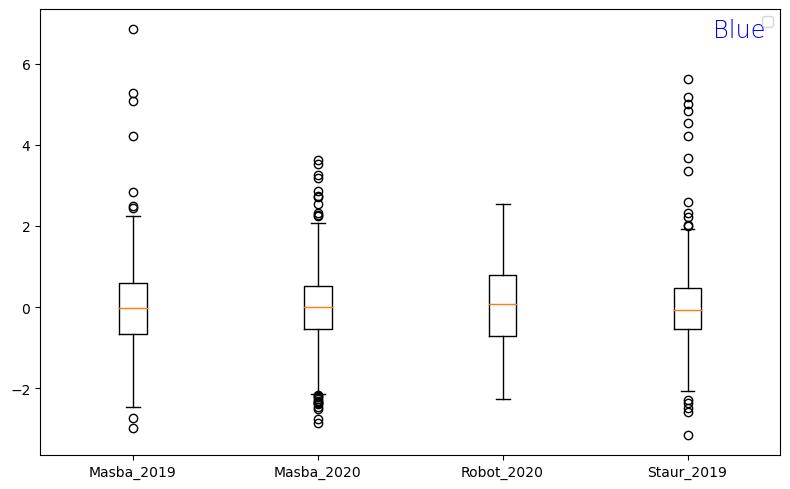

No handles with labels found to put in legend.


5.088317132655507
4.832762961032385
2.2719094504788755
6.338076064070179


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


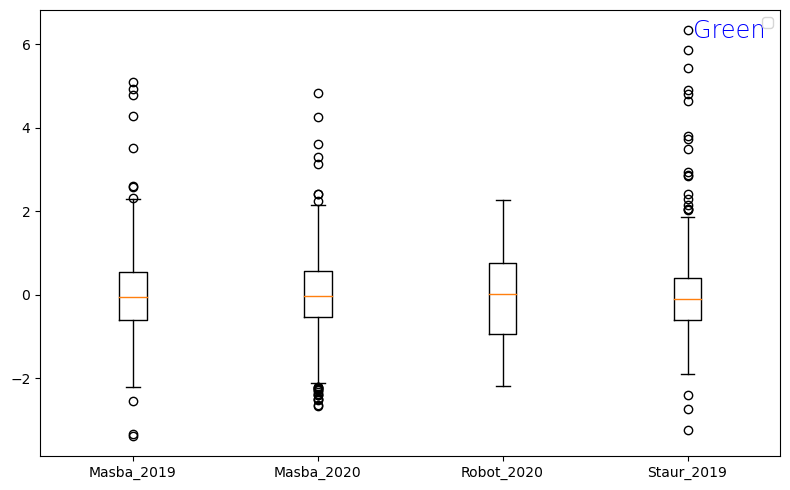

No handles with labels found to put in legend.


6.816246141420547
6.818745182589411
2.7493973329967534
5.413865337663863


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


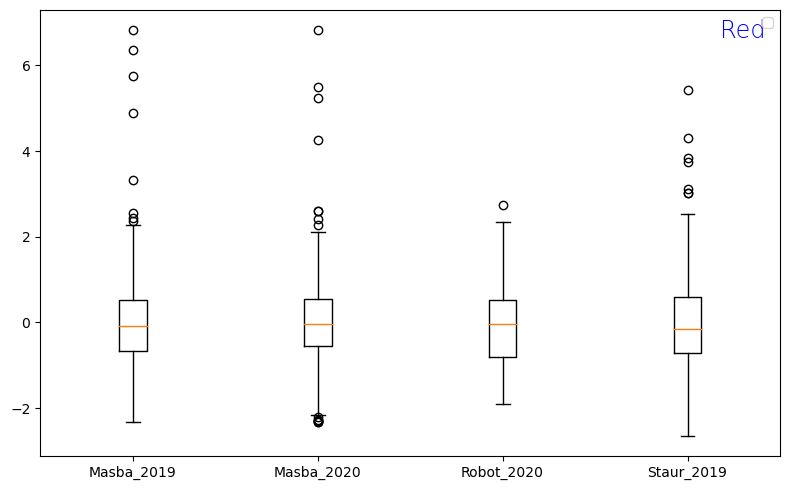

No handles with labels found to put in legend.


5.09340880177228
6.179592043315468
2.062062104959449
6.371379842589115


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


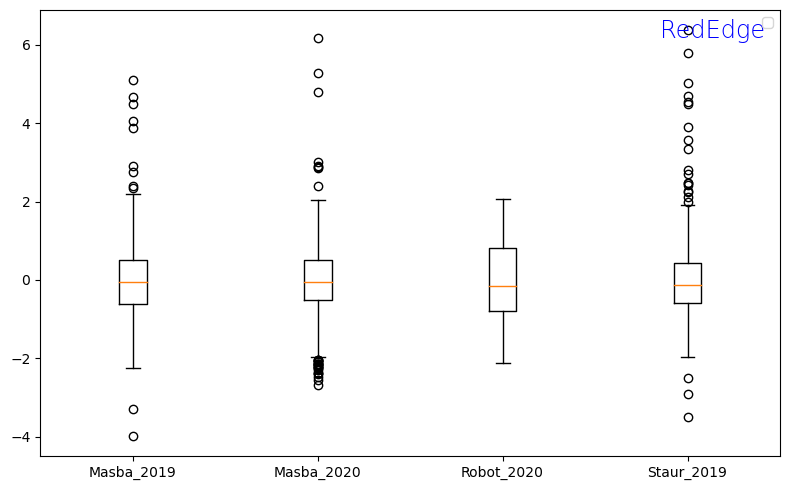

No handles with labels found to put in legend.


2.40376011019284
6.217376457814917
2.1555474166876625
2.87965584654517


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


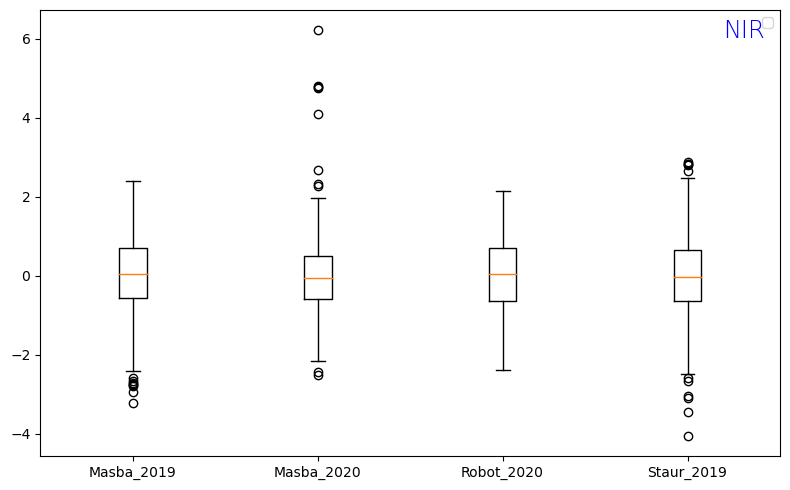

No handles with labels found to put in legend.


1.9927853650342282
2.295396055213618
2.196153400034985
1.709747901106168


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


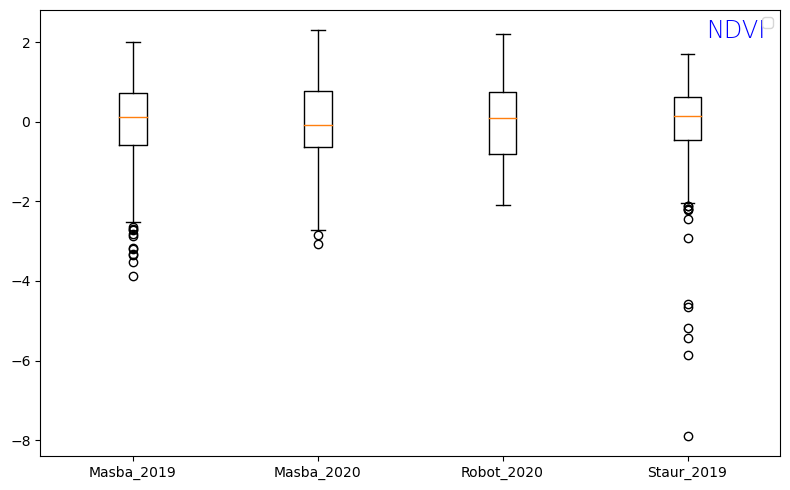

No handles with labels found to put in legend.


2.4075658426961617
5.48548386574031
1.8772867023062387
2.739696091918508


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


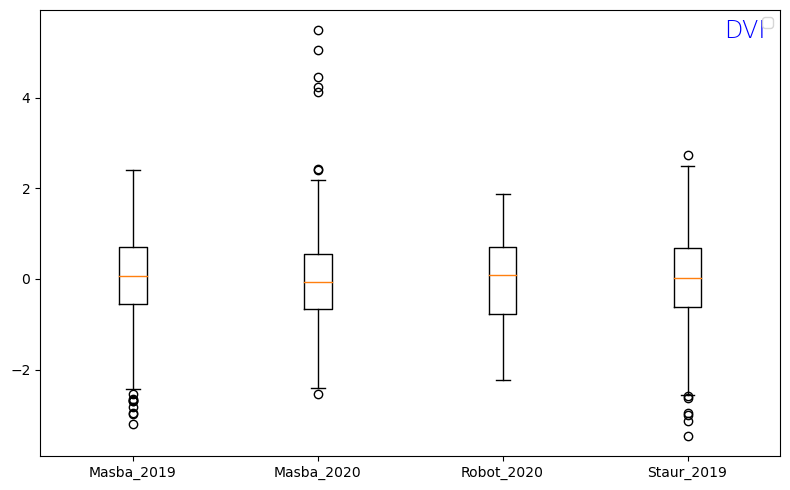

No handles with labels found to put in legend.


2.117516258874545
6.129178287286351
1.954135532975814
2.776904746251701


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


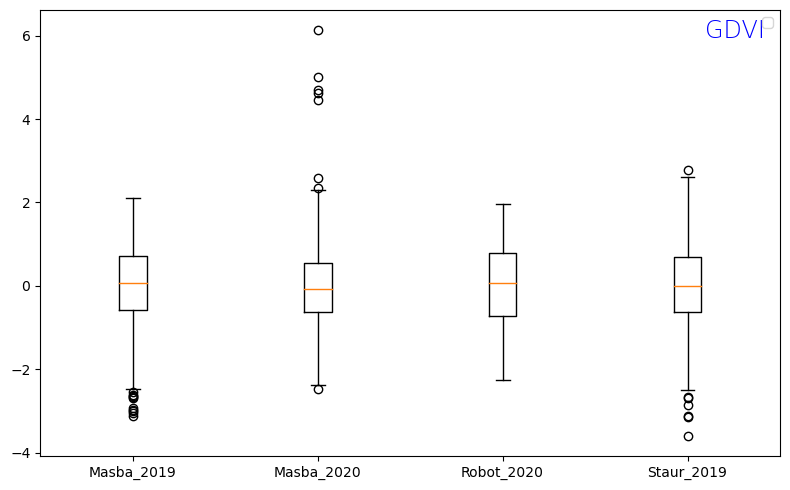

No handles with labels found to put in legend.


3.7238802838327927
3.282772137241259
3.1138101081057585
5.291053818780792


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


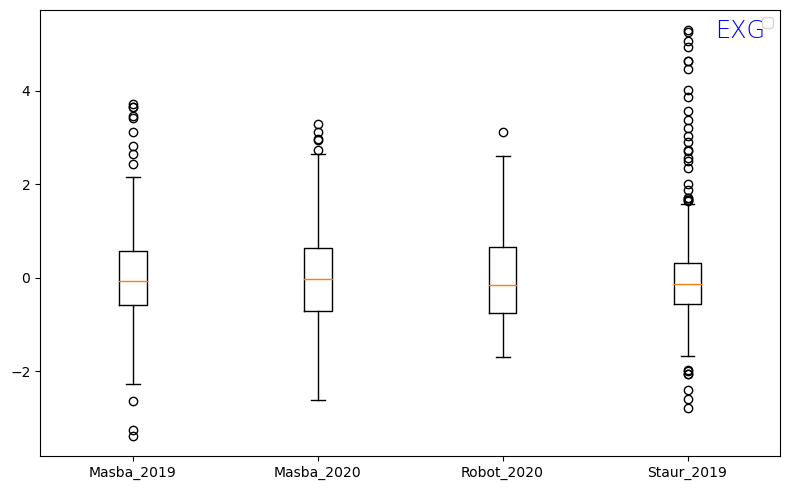

No handles with labels found to put in legend.


3.5964562783017406
2.78086675103933
2.5478594662244474
5.083504062375923


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


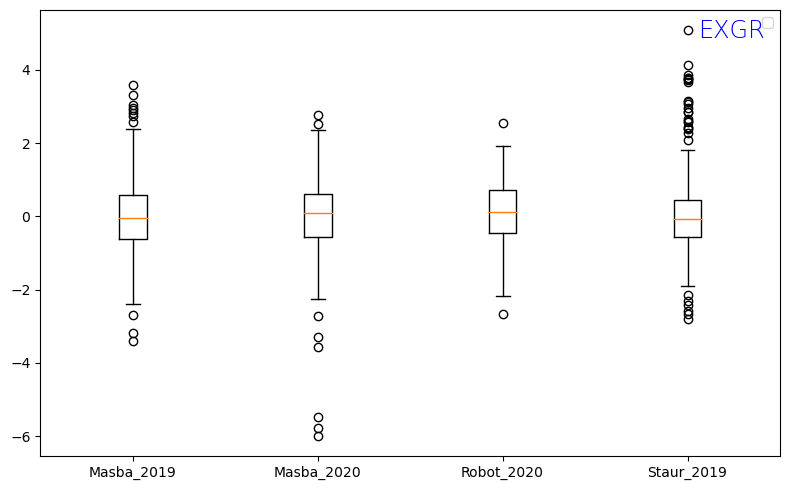

No handles with labels found to put in legend.


2.438272936753706
3.030353083097715
1.798635670165483
2.297413339474319


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


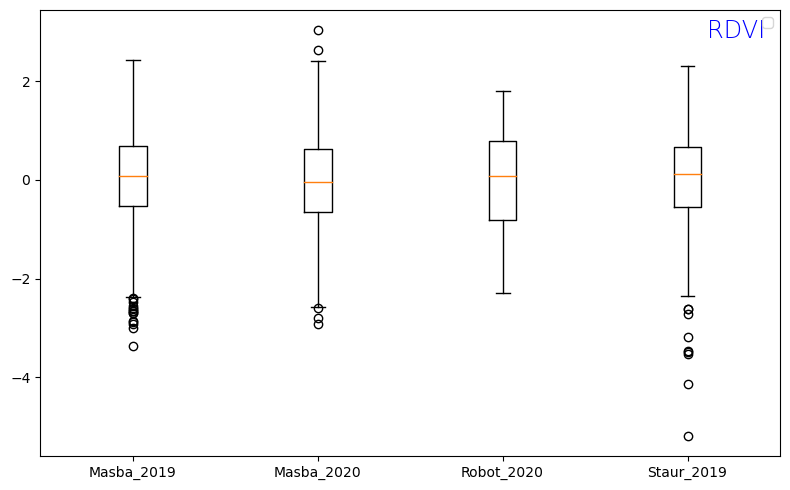

No handles with labels found to put in legend.


2.349045090960982
2.607685174112686
1.777206059857291
2.333699077233992


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


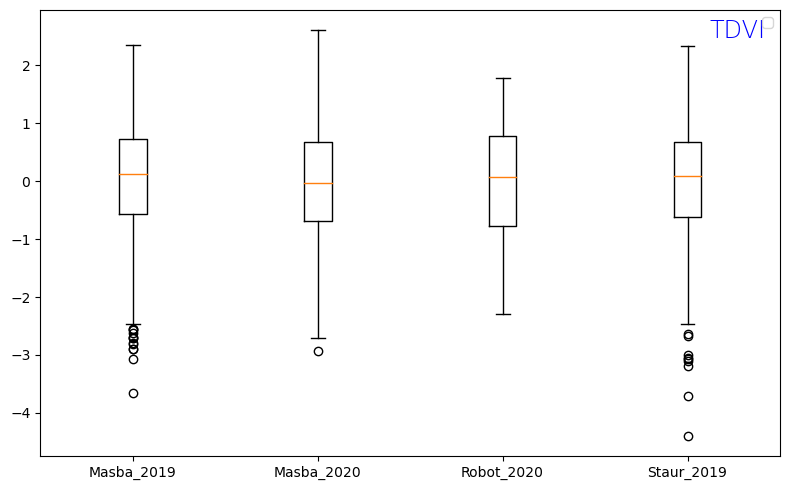

No handles with labels found to put in legend.


2.225346021904733
2.0974525540620865
2.009638397856866
1.7539597382202008


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


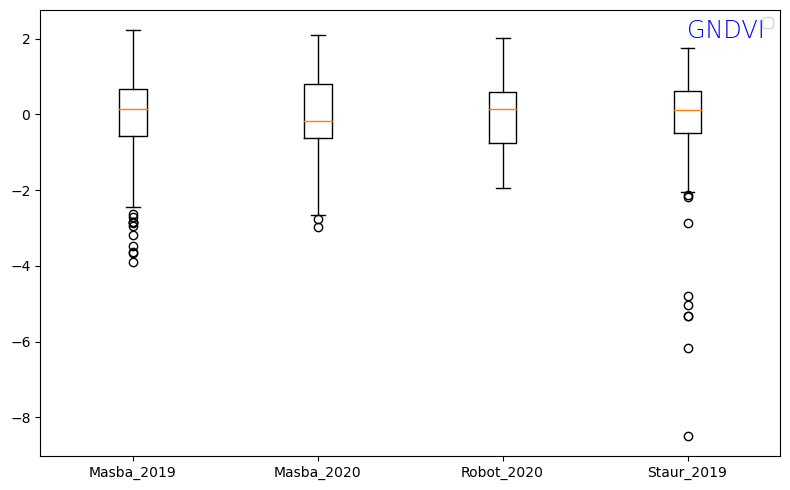

No handles with labels found to put in legend.


2.768828275375385
2.4880054338642874
1.595240090586611
2.237897037761945


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


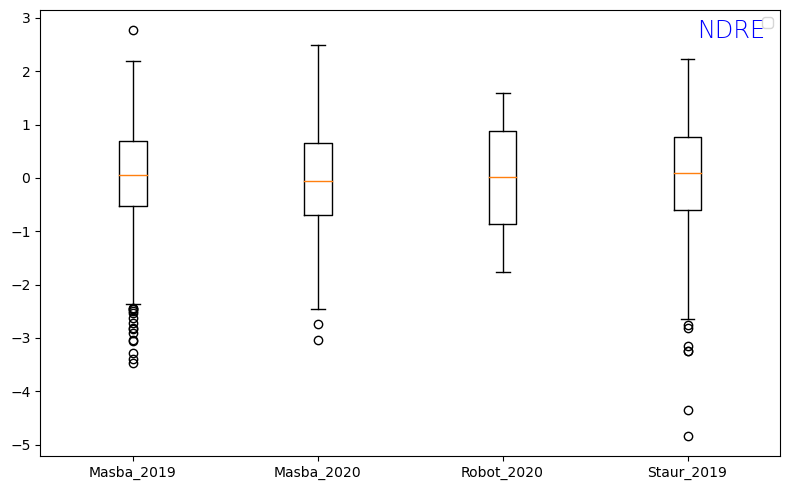

No handles with labels found to put in legend.


3.1530910909577585
2.1039856277452182
1.927805332653258
2.061638856658587


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


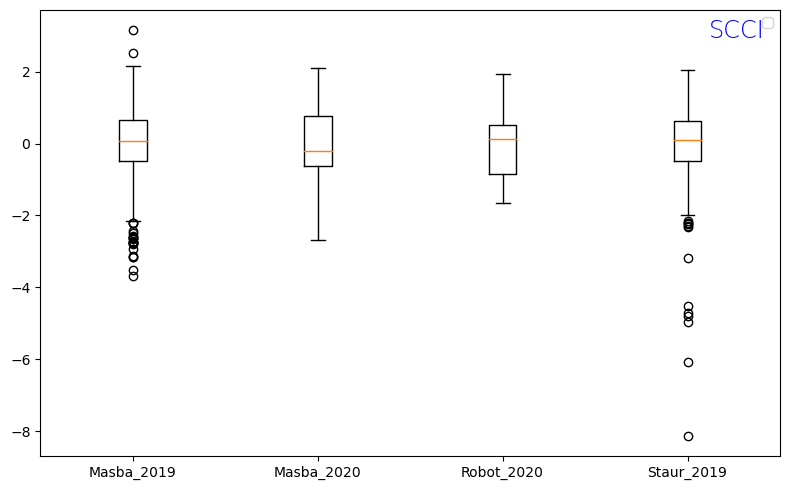

No handles with labels found to put in legend.


2.5781823228052185
5.050358017041777
2.0135965680235763
2.711438938166247


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


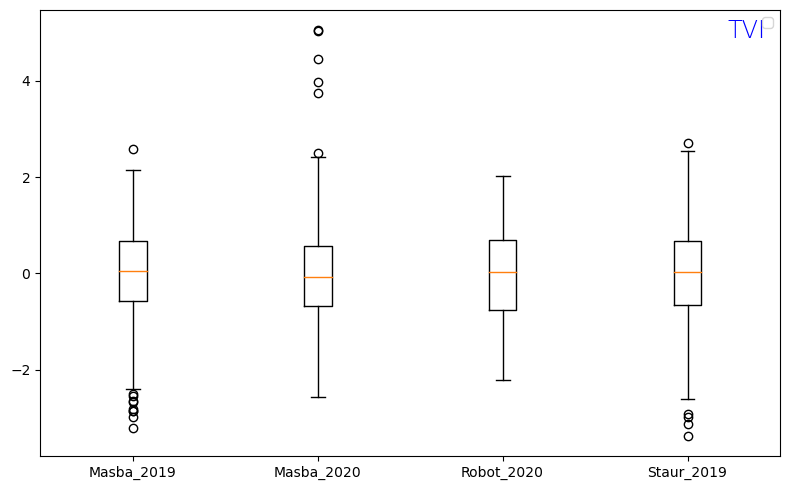

No handles with labels found to put in legend.


2.517124328487842
2.4603337380050903
2.271936735678876
2.6047777598206467


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


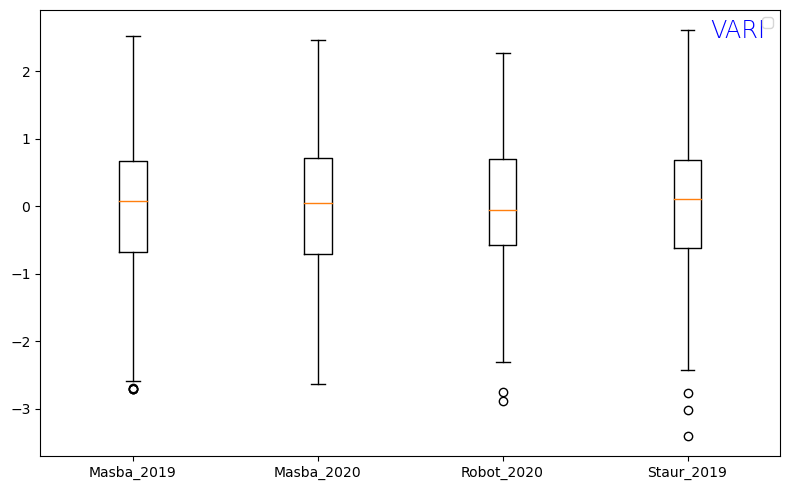

No handles with labels found to put in legend.


2.14178504630633
2.775160277419795
1.7314616829983467
1.9763638741132896


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


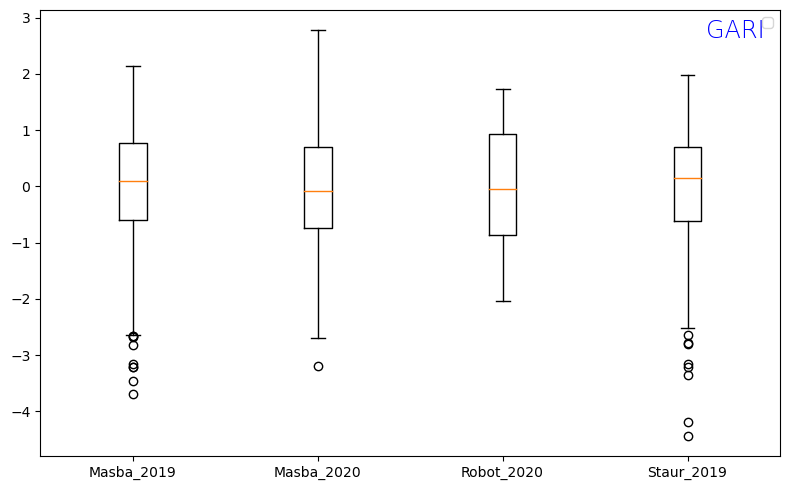

No handles with labels found to put in legend.


2.665275296038528
2.7291992466547783
1.7864468516387004
2.7440629652832644


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


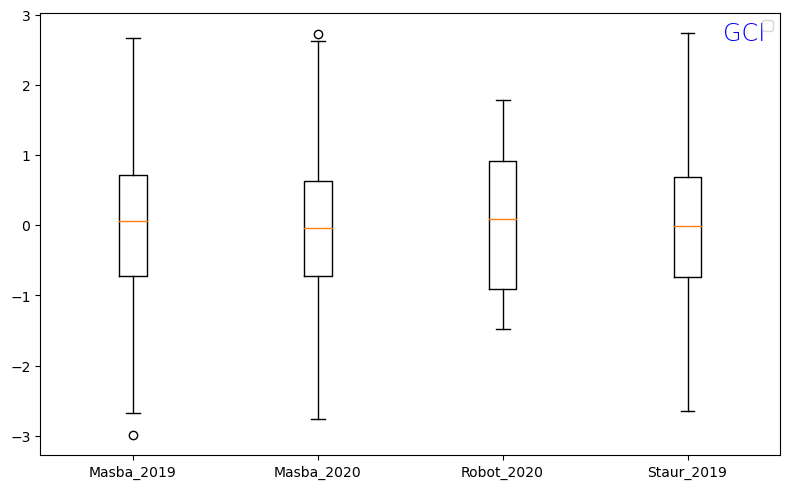

No handles with labels found to put in legend.


1.8747767836154083
2.64888613687809
1.9754427624916158
1.9504132045981744


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


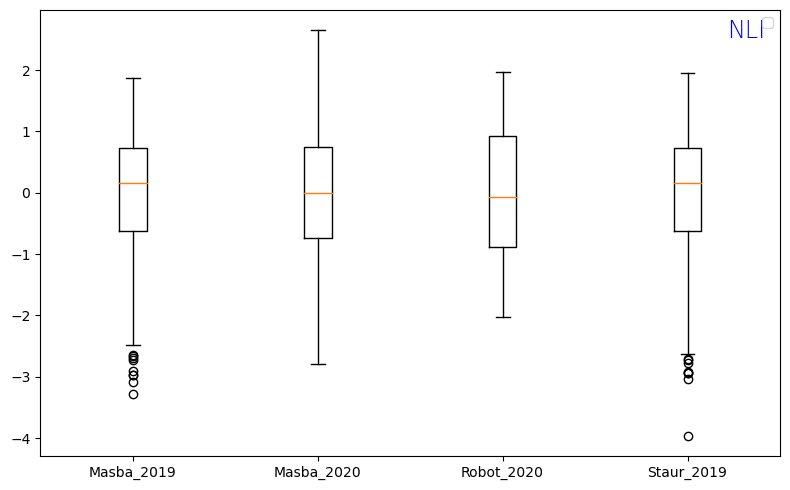

No handles with labels found to put in legend.


2.412715981539609
3.8186497343606716
2.039093303540255
2.5542067424152557


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


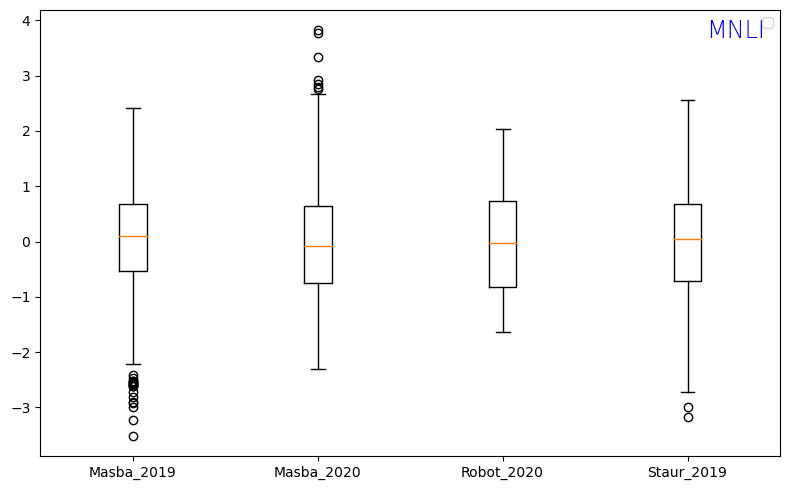

No handles with labels found to put in legend.


2.3376650302043127
2.5560421045880948
1.749485268744943
2.25557945838408


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


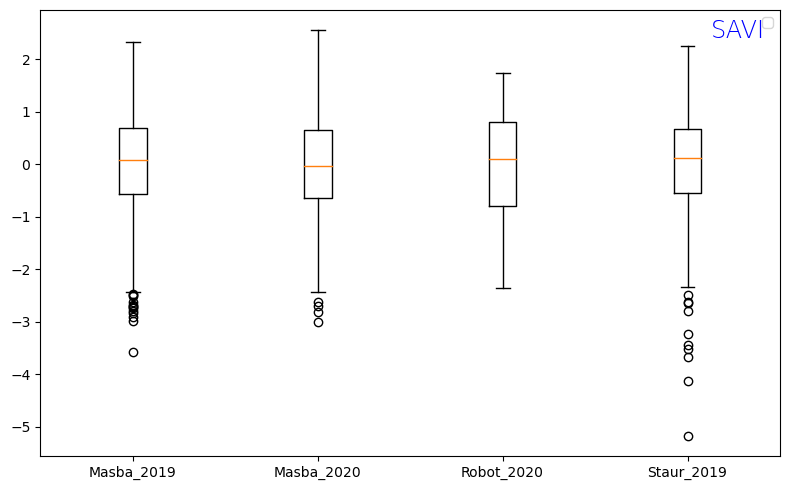

No handles with labels found to put in legend.


1.8662071024449922
2.6399207245940413
1.8753635034959344
2.431393021398564


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


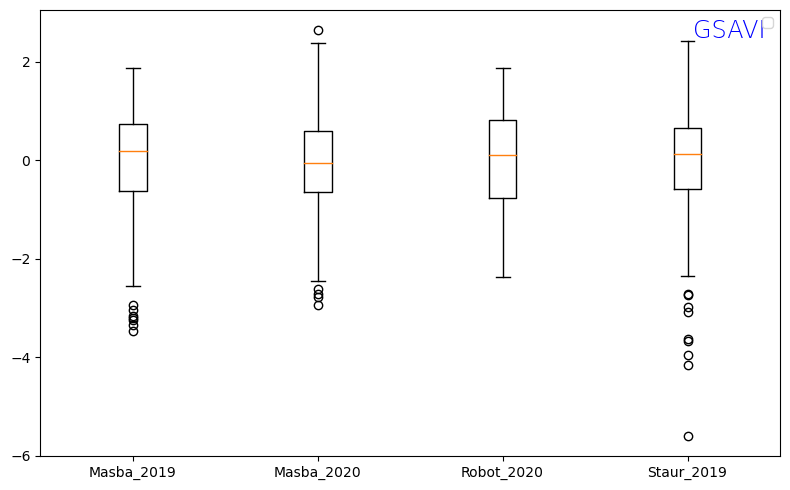

No handles with labels found to put in legend.


2.139294359219429
2.410071542923245
1.8665037627491214
2.0308382722524025


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


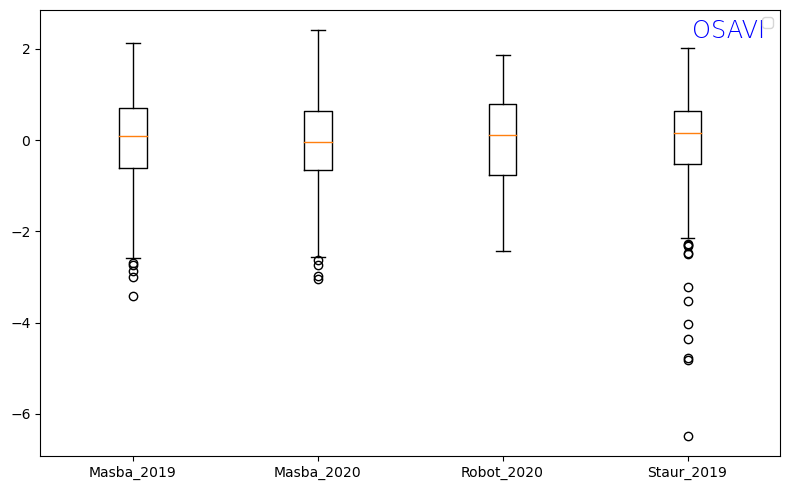

No handles with labels found to put in legend.


1.8193931802512697
2.257300505504799
1.827980054868621
2.1658612136897037


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


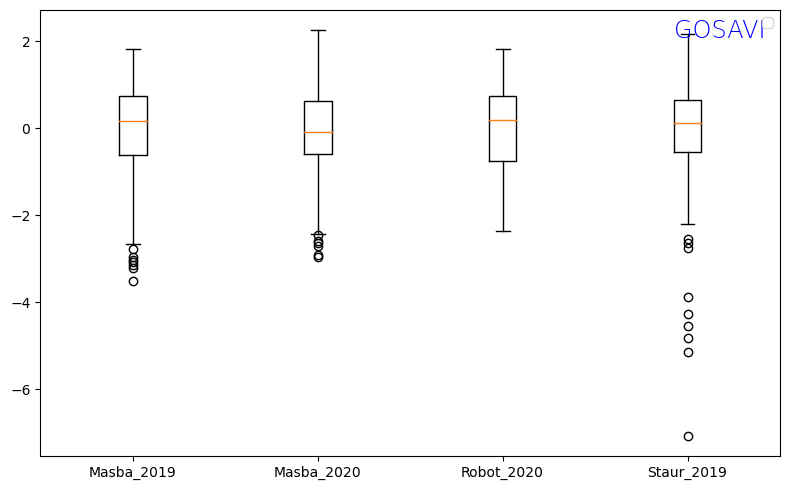

No handles with labels found to put in legend.


2.3844854785346308
2.690313948191485
2.074814048895858
2.241102286159587


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


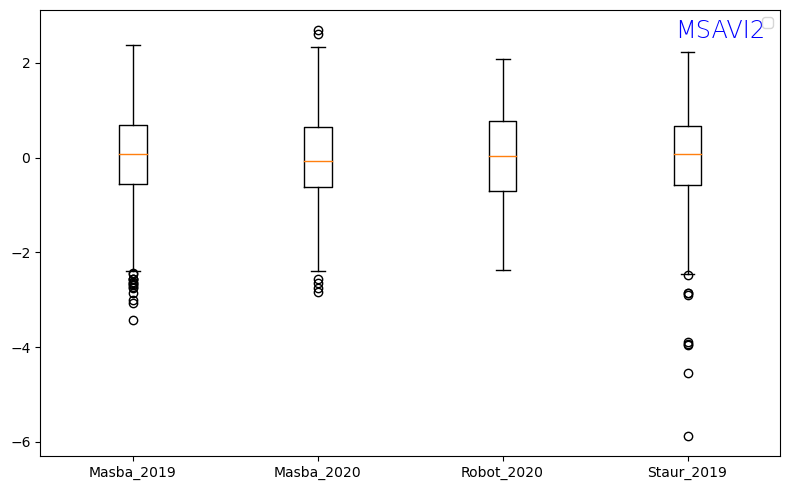

No handles with labels found to put in legend.


2.4349122667643632
2.619550246487262
2.0805867274760157
3.0256309891602653


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


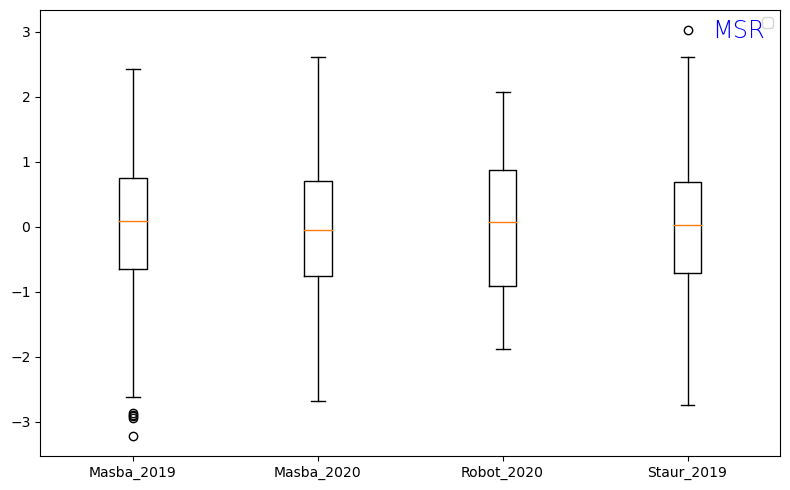

No handles with labels found to put in legend.


2.6652752960385255
2.6753693444975237
1.7227855636219507
2.732496763195824


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


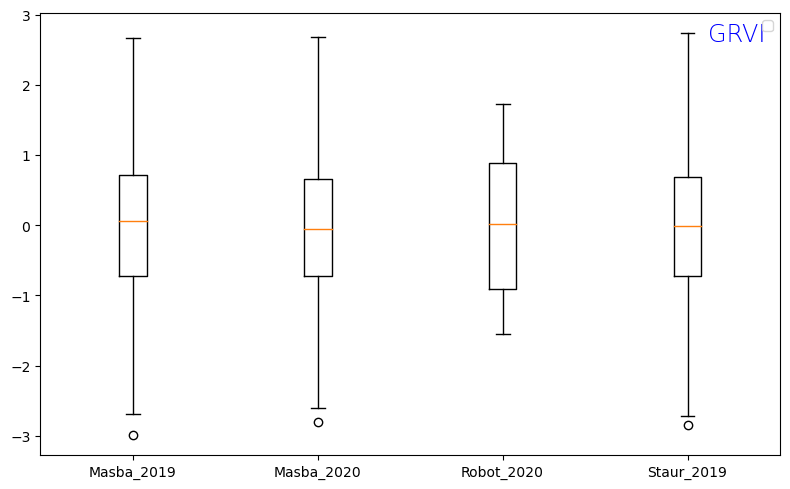

No handles with labels found to put in legend.


2.256463518143295
2.502457946128782
2.1806832471386577
2.5011808705848666


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


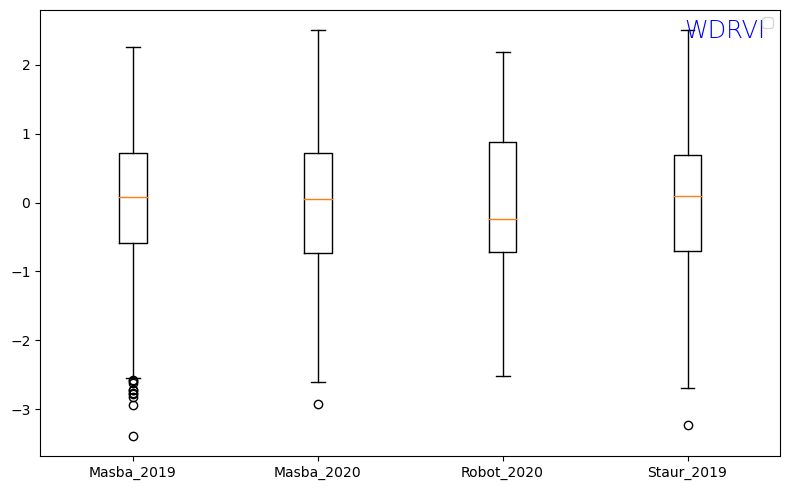

No handles with labels found to put in legend.


2.507997542359989
2.779604951543792
2.254873656754963
3.5073397005222917


<ipython-input-32-9a984777454a>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transform" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)


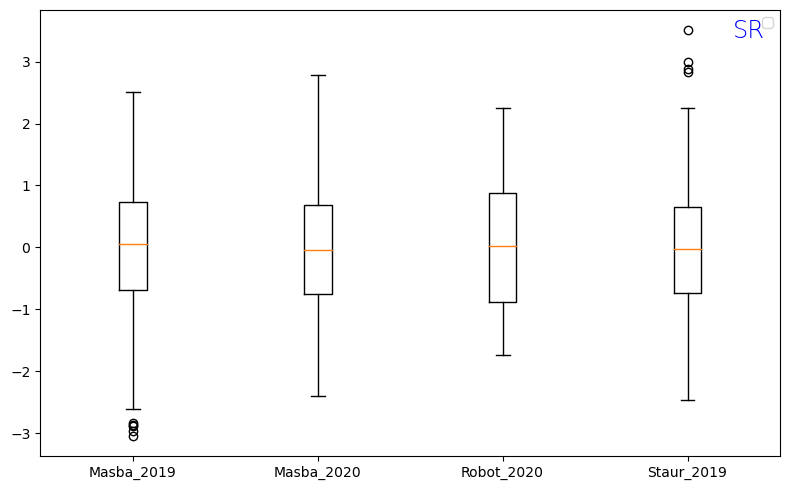

In [32]:
# for col in base_indices+spectral_indices:
# #     col='Blue'
#     fig_size=(8, 5)
#     fig, ax = plt.subplots(figsize=fig_size)
#     plots = ax

#     for df in all_df_simps:
# #         if not 'Robot' in df and  not 'Staur' in df:
# #         if 'Gram' in df and  'Masb' in df:
# #             if '2020' in df:
#         temp_df = locals()[df].copy()
#         print(temp_df[col].values.max())
#         ax.boxplot(sorted(temp_df[col].values), positions = [all_df_simps.index(df)], labels=[df.split('_')[0][:5]+'_'+df.split('_')[1]])
# #         ax.plot(sorted(temp_df[col].values), label=df.split('_')[0]+'_'+df.split('_')[1])
#     # Printing the band/index name in plot of the fiels_sample for reference
#     text = col
#     ax.text(.98, .98, text, ha='right', va='top', weight=100, color='blue', fontsize ='xx-large', transform=ax.transAxes)

#     ax.legend(loc=1)
#     plt.tight_layout()
#     plt.savefig(export_path_comparability+col+'_norm_box.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)
#     plt.show()
# #     break

# Correlation

## Scatter Plot

In [ ]:
for df in all_df_simps:
    temp_df = locals()[df][base_indices+spectral_indices+[target_features[0]]].copy()
    data = temp_df.copy()
    for col in base_indices:
        print(df)
        df_a = temp_df[col]
        df_b = temp_df[target_features[0]]


        fig, ax = plt.subplots(1, figsize=(12,8))
        sns.kdeplot(df_a, y=df_b, cmap='Blues',
                   shade=True, thresh=0.05, clip=(-1,300))
        plt.scatter(df_a, df_b, color='orangered')
        plt.show()

## Heat Map

In [ ]:
for df in all_df_simps:
    print(df)
    temp_df = locals()[df][[target_features[0]]+spectral_indices].copy()
#     temp_df = locals()[df][spectral_indices+[target_features[0]]].copy()
    data = temp_df
    columns = temp_df.columns
    corr = data.corr(method='pearson')
    fig_size=(15,8)

    fig, ax = plt.subplots(figsize=fig_size)
    
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    
    ax = sns.heatmap(
        corr, mask=mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )    
    
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
#     plt.savefig(export_path+df+'_corr.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)

    plt.show()

## Final

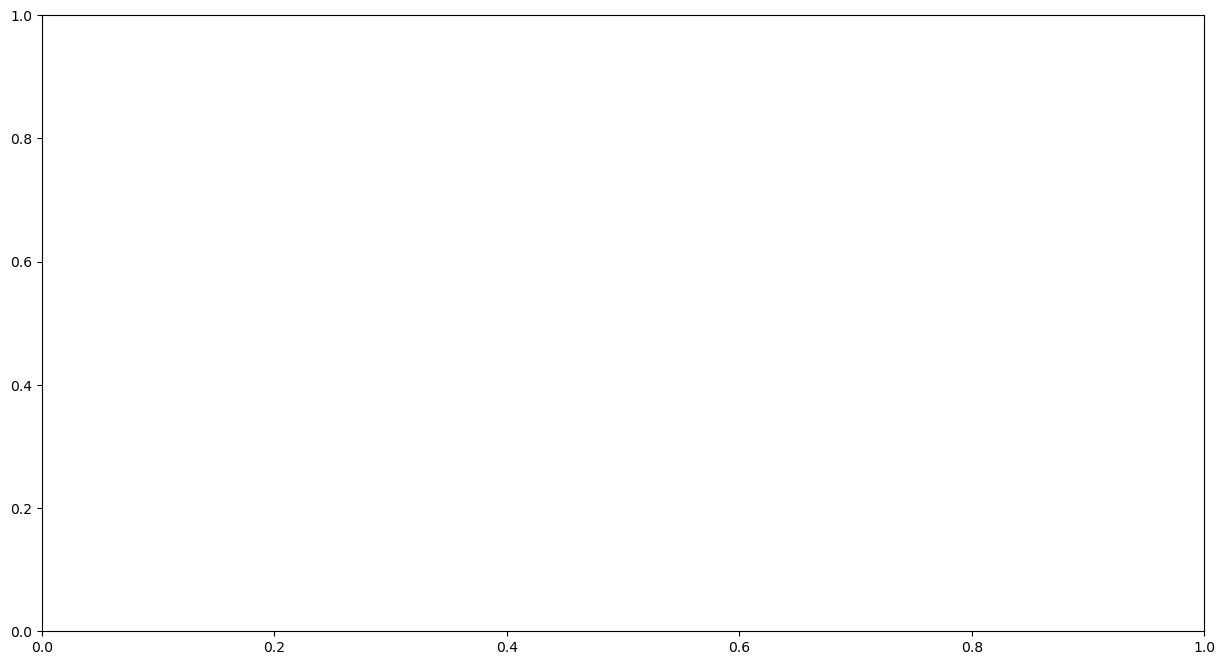

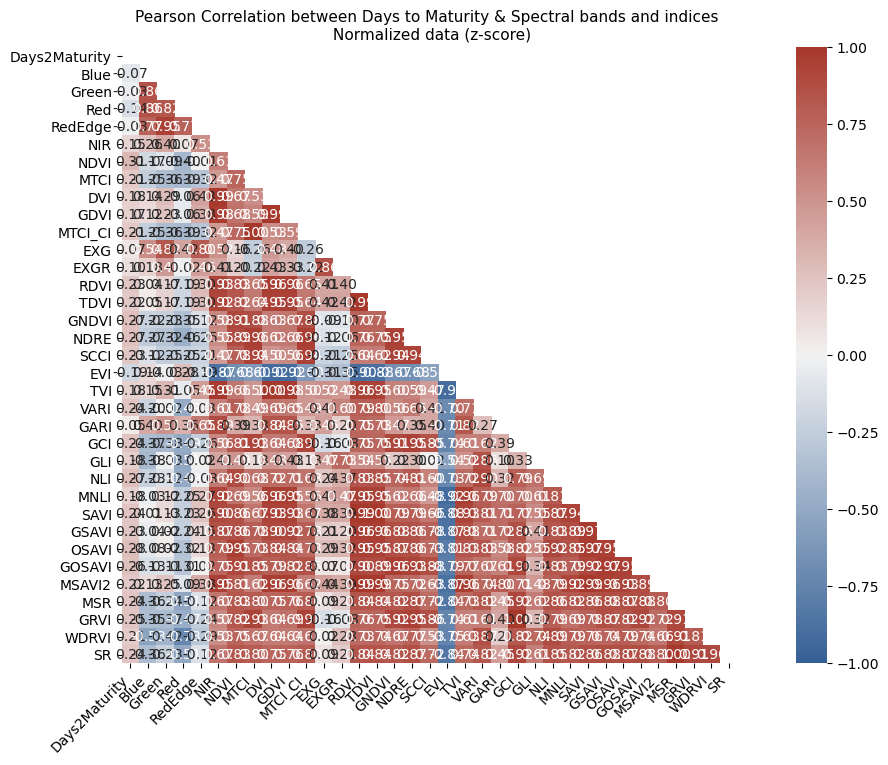

In [173]:
temp_list = [x for x in all_df_simps if not 'Robot' in x]

# Making list of df for conct before training
# This is different form list of srtings, as this is a list of actual dataframes
df_list = []
for x in temp_list:
    df_list.append(locals()[x])

df_ = pd.concat(df_list)

data = df_[[target_features[0]]+base_indices+spectral_indices_all]
columns = df_[[target_features[0]]+base_indices+spectral_indices_all].columns
corr = data.corr(method='pearson')
fig_size=(15,8)

fig, ax = plt.subplots(figsize=fig_size)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# cmap = sns.diverging_palette(250, 15, s=75, l=40,
#                              n=9, center="light", as_cmap=True)
# ax = sns.heatmap(
#     corr, mask=mask,
#     vmin=-1, vmax=1, center=0,
#     annot=True,fmt='.2f', square=True, cmap=cmap
    

ax = sns.heatmap(
    corr, mask=mask,fmt='.2f',
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)    

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

if target_features == ['GrainYield']:
    ax.set_title('Pearson Correlation between Grain Yield & Spectral bands and indices \n Normalized data (z-score)',
                fontdict = {'fontsize' : 11})
#     plt.savefig(export_path+'all_mix_corr_norm_GY.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)

if target_features == ['Days2Maturity']:
    ax.set_title('Pearson Correlation between Days to Maturity & Spectral bands and indices \n Normalized data (z-score)',
                fontdict = {'fontsize' : 11})
#     plt.savefig(export_path+'all_mix_corr_norm_DM.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)

# if target_features == ['GrainYield']:
#     ax.set_title('Pearson Correlation between Grain Yield & Spectral bands and indices \n Not normalized data (z-score)',
#                 fontdict = {'fontsize' : 11})
#     plt.savefig(export_path+'all_mix_corr_normNA_GY.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)

# if target_features == ['Days2Maturity']:
#     ax.set_title('Pearson Correlation between Days to Maturity & Spectral bands and indices \n Not normalized data (z-score)',
#                 fontdict = {'fontsize' : 11})
#     plt.savefig(export_path+'all_mix_corr_normNA_DM.jpg',dpi=250, bbox_inches='tight', transform=ax.transAxes)

plt.show()

## Restart the kernel

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")